# Detecting sleep states data visualization

## Imports and loading of the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We work on the smaller sets of data that contains only data from one series_id

In [2]:
sample_submission = pd.read_csv('sample_submission.csv')
test_series = pd.read_pickle('test_series.pkl')
train_series = pd.read_pickle('train_series.pkl')
train_events = pd.read_pickle('train_events.pkl')

In [18]:
train_series.head(5)

,series_id,step,timestamp,anglez,enmo,date,time,hour
0,d043c0ca71cd,0,2018-12-26 11:15:00,-16.815399,0.0693,2018-12-26,11:15:00,11
1,d043c0ca71cd,1,2018-12-26 11:15:05,-13.815700,0.0386,2018-12-26,11:15:05,11
2,d043c0ca71cd,2,2018-12-26 11:15:10,-9.894600,0.1192,2018-12-26,11:15:10,11
3,d043c0ca71cd,3,2018-12-26 11:15:15,-17.673599,0.0874,2018-12-26,11:15:15,11
4,d043c0ca71cd,4,2018-12-26 11:15:20,-20.264000,0.1146,2018-12-26,11:15:20,11


In [19]:
train_events.head(5)

,series_id,night,event,step,timestamp,date,time,hour
0,d043c0ca71cd,1,onset,7032.0,2018-12-26 21:01:00,2018-12-26,21:01:00,21
1,d043c0ca71cd,1,wakeup,13572.0,2018-12-27 06:06:00,2018-12-27,06:06:00,6
2,d043c0ca71cd,3,onset,42396.0,2018-12-28 22:08:00,2018-12-28,22:08:00,22
3,d043c0ca71cd,3,wakeup,48600.0,2018-12-29 06:45:00,2018-12-29,06:45:00,6
4,d043c0ca71cd,4,onset,59820.0,2018-12-29 22:20:00,2018-12-29,22:20:00,22


We drop all the nulls to make it easier to display the plots

In [5]:
print(train_events.shape)
train_events = train_events.dropna()
print(train_events.shape)

(64, 5)
(64, 5)


In [6]:
print(train_series.shape)
train_series = train_series.dropna()
print(train_series.shape)

(745020, 5)
(745020, 5)


## Preparing the time series

We delete the index of the dataframes and from the timestamp column we create new columns that are date, time, hour

In [7]:
train_series = train_series.reset_index(drop=True)

In [8]:
train_events = train_events.reset_index(drop=True)
train_events['date'] = train_events['timestamp'].str.split('T', expand=True)[0]
train_events['time'] = train_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_events['timestamp'] = pd.to_datetime(train_events['date'] + ' ' + train_events['time'])
train_events['hour'] = train_events['timestamp'].dt.hour

In [9]:
train_series = train_series.reset_index(drop=True)
train_series['date'] = train_series['timestamp'].str.split('T', expand=True)[0]
train_series['time'] = train_series['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_series['timestamp'] = pd.to_datetime(train_series['date'] + ' ' + train_series['time'])
train_series['hour'] = train_series['timestamp'].dt.hour

Filtering the data in the train_series to fit the one in the train_events

In [10]:
train_events.sort_values(by=['timestamp'], inplace=True)
earliest_timestamp = train_events.iloc[0]['date']
latest_timestamp = train_events.iloc[-1]['date']

In [11]:
train_series = train_series[(train_series['date'] >= earliest_timestamp) & (train_series['date'] <= latest_timestamp)]
train_series.reset_index(drop=True, inplace=True)
train_series.shape

(745020, 8)

## Plots

The plot below shows the number of the events per hour for the one person.

In orange we can see the wakeups of the person.

In blue there are onsets.

So we can conclude that onsets are mainly from 20:00-01:00 and the wakeups at about 06:00-08:00.

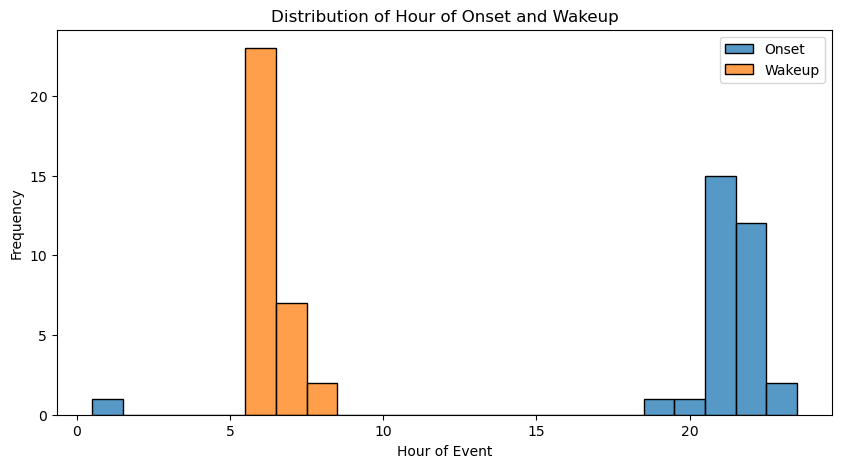

In [12]:
# Set figure size
plt.figure(figsize=(10, 5))

# Assuming your DataFrame is called train_events
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

# Plotting the distribution plot for onset events
sns.histplot(df_onset['hour'].dropna(), kde=False, bins=24, label='Onset', discrete=True)  # You can adjust bins as needed

# Plotting the distribution plot for wakeup events
sns.histplot(df_wakeup['hour'].dropna(), kde=False, bins=24, label='Wakeup', discrete=True)  # You can adjust bins as needed

# Adding labels and title
plt.xlabel('Hour of Event')
plt.ylabel('Frequency')
plt.title('Distribution of Hour of Onset and Wakeup')
plt.legend()

# Show the plot
plt.show()

In [13]:
def plot_series_with_events(series_id, train_series, train_events):
    # Filter the DataFrame based on the series_id
    sample_serie = train_series[train_series['series_id'] == series_id]

    
    # Filter event data based on the series_id
    sample_events = train_events[train_events['series_id'] == series_id]
    sample_onset = sample_events.loc[sample_events['event'] == 'onset', 'timestamp'].dropna()
    sample_wakeup = sample_events.loc[sample_events['event'] == 'wakeup', 'timestamp'].dropna()
    
    # Helper function to plot data and events
    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 3))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=1)
        
        for onset in sample_onset:
            plt.axvline(x=onset, color='r', linestyle='--', label='onset')
            
        for wakeup in sample_wakeup:
            plt.axvline(x=wakeup, color='g', linestyle='--', label='wakeup')
            
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
        
        plt.legend(new_handles, new_labels)
        plt.xlabel('Timestamp')
        plt.ylabel(ylabel)
        plt.title(f'{ylabel} over Time with Event Flags - '+series_id)
        plt.show()
    
    # Plot enmo and anglez
    plot_data_and_events('enmo', 'ENMO Value')
    plot_data_and_events('anglez', 'anglez Value')

The most important features in the data provided are enmo and anglez

The graph below shows the enmo value in time with the wakeups and onsets shown on the plot

As we can see when the person sleeps the enmo values are much lower than during the day

However there is also a problem that the onsets and wakeups are not specified every day, that means that the quality of data is not perfect

The similar situation is about anglez values. We can see that during sleeping the values differ from the ones after getting up

However, the differences are not as visible as in the enmo graphs

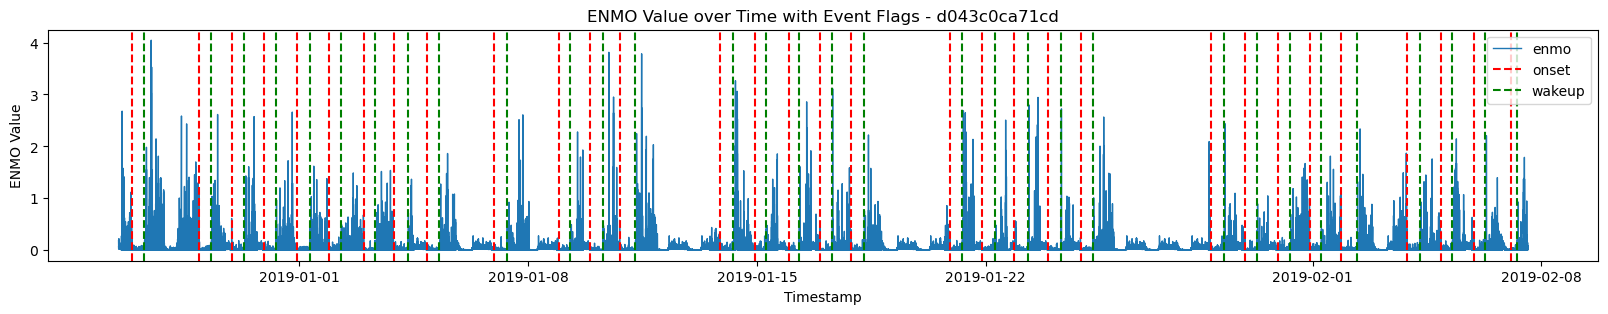

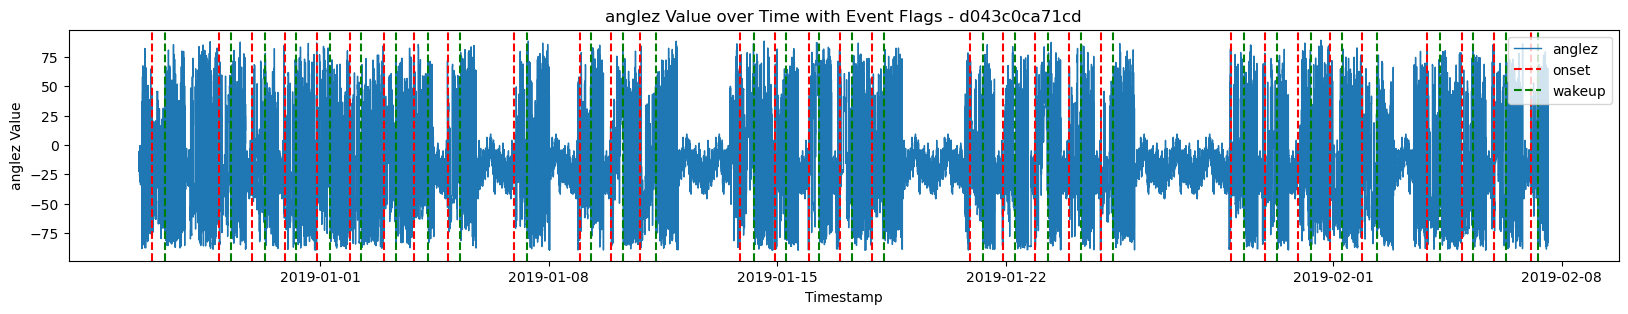

In [14]:
for series_id in train_events['series_id'].unique():
    plot_series_with_events(series_id, train_series, train_events)

Below we can see how does it look like on the sample submission file

When the events should be detected

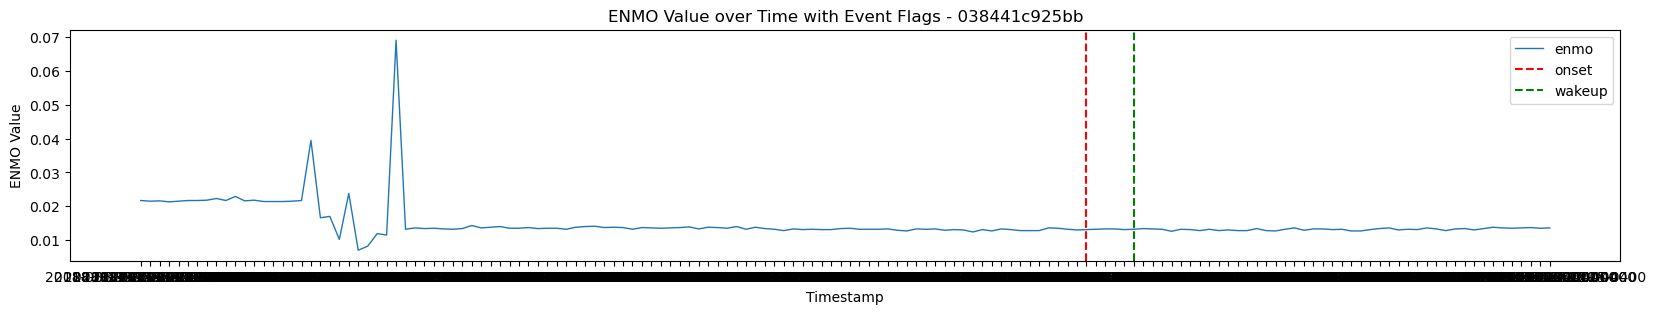

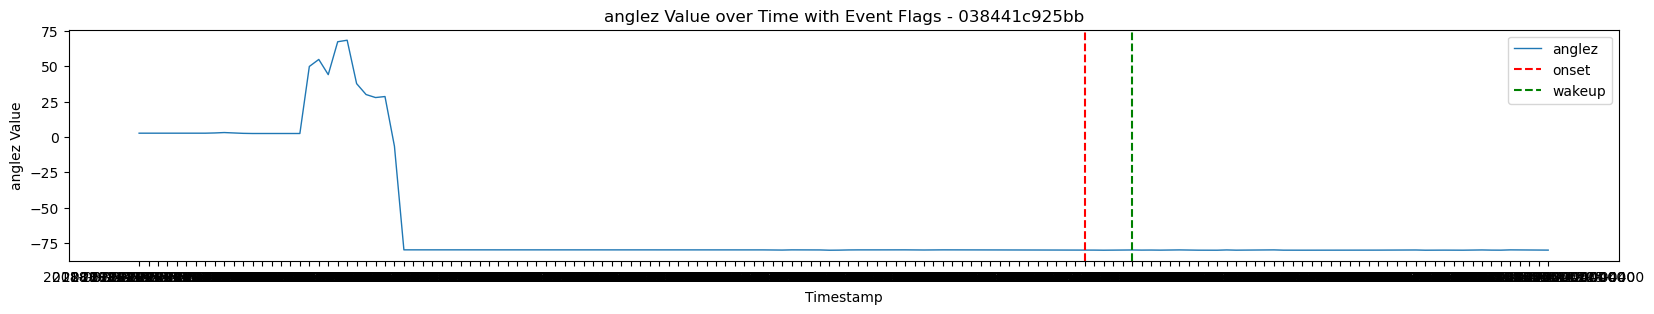

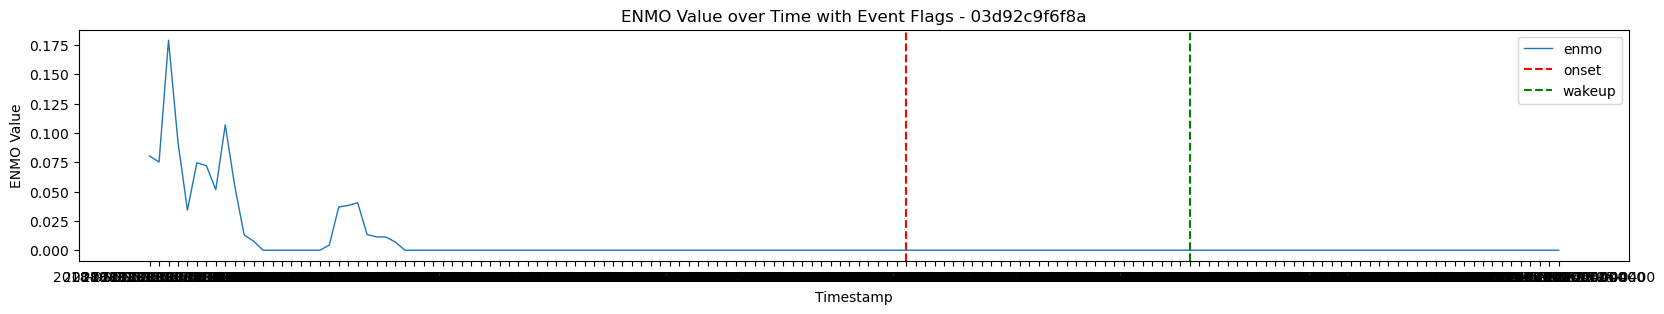

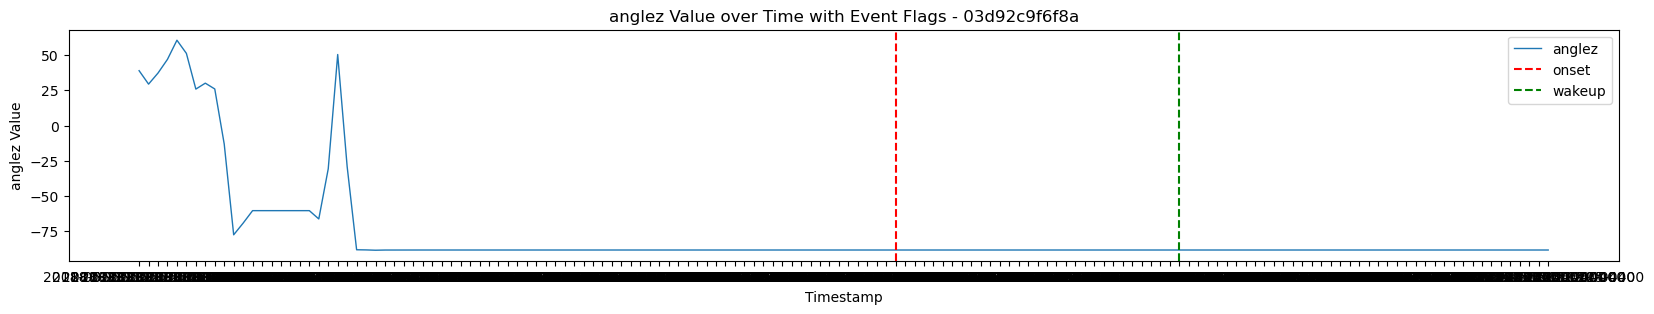

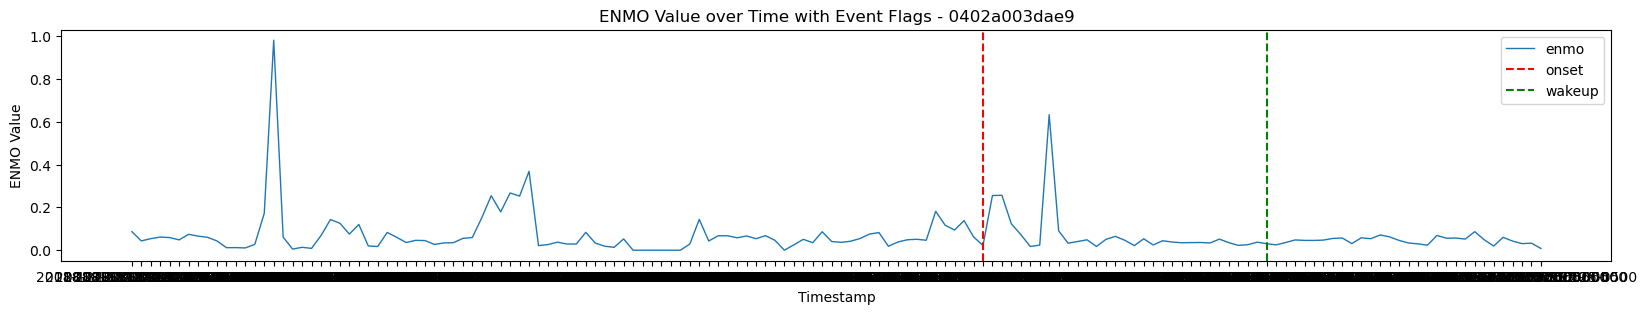

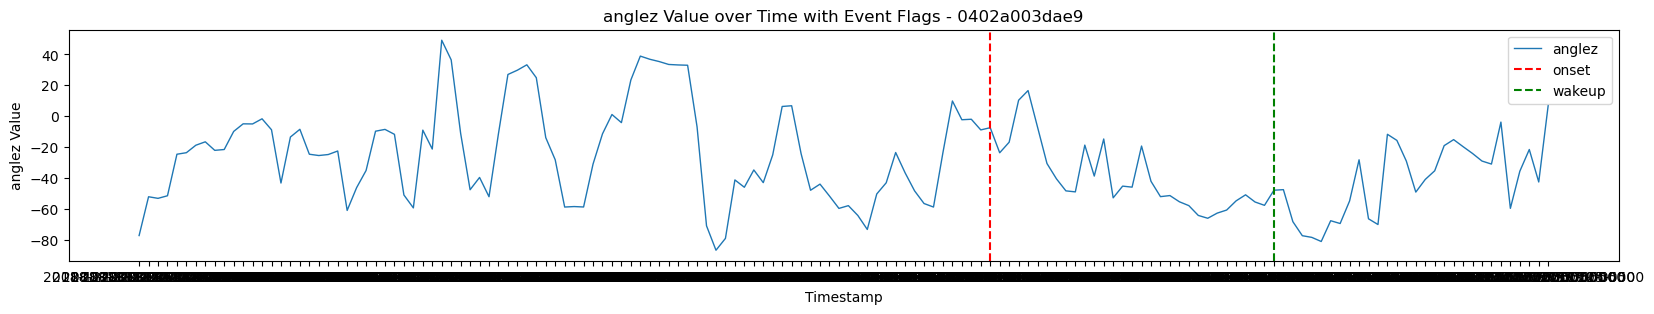

In [16]:
tmp_test_events = sample_submission.merge(test_series, on=['series_id','step'],how='left')

for series_id in tmp_test_events['series_id'].unique():
    plot_series_with_events(series_id, test_series, tmp_test_events)